# Analyse graphique de DVF pour Paris


1. [La table mutation](#mutation)
    1. [Définition de l'étude](#def)
        1. [Le type de bien](#type_de_bien)
        2. [La nature de la mutation](#nature_mutation)
    2. [Traitement des variables](#traitement)
        1. [Les variables inutiles](#useless)
        2. [Le traitement des valeurs manquantes](#missing)
        3. [Comprendre les variables restantes](#comprendre)
        4. [Comment prendre en compte l'évolution du prix des biens immobilier](#insee)
    3. [Synthèse: la table mutation](#synthese_mut)
2. [Représentation géospatiale de nos données](#geo)
    1. [Prise en main des différents dataset](#avenger)
        1. [Agréger les différentes tables](#agrege)
        2. [Rapide analyse : découverte des outils de mapping de GeoPandas](#geomap)

In [43]:
import pandas as pd
pd.set_option("max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import missingno as msno
import geopandas as gdp
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import math
# Need : mapclassify

<a id= "mutation"></a>

## 1. La table mutation : le cas de Paris

In [62]:
paris_mutation= pd.read_csv("data/unziped_csv/r11/r11_amutation.csv")
# We only keep Mutation done at Paris
paris_mutation= paris_mutation[paris_mutation["coddep"] == 75].reset_index(drop= True)
paris_mutation.head()

,idmutation,idmutinvar,idopendata,idnatmut,codservch,refdoc,datemut,anneemut,moismut,coddep,libnatmut,nbartcgi,l_artcgi,vefa,valeurfonc,nbdispo,nblot,nbcomm,l_codinsee,nbsection,l_section,nbpar,l_idpar,nbparmut,l_idparmut,nbsuf,sterr,l_dcnt,nbvolmut,nblocmut,l_idlocmut,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,nbapt5pp,nbmai1pp,nbmai2pp,nbmai3pp,nbmai4pp,nbmai5pp,sbati,sbatmai,sbatapt,sbatact,sapt1pp,sapt2pp,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,libtypbien
0,5863434,6db153bc881f7f65454f7ee39728a06c,6db153bc881f7f65454f7ee39728a06c,1,NaN,NaN,2014-05-13,2014,5,75,Vente,0,NaN,f,3.533931e+07,1,0,1,{75115},1,{ER},1,{75115000ER0123},0,NaN,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,102,BATI - INDETERMINE : Vente avec volume(s)
1,5454034,1791301cde144e9854412489de4c1d14,1791301cde144e9854412489de4c1d14,1,NaN,NaN,2017-03-07,2017,3,75,Vente,0,NaN,f,2.070000e+05,1,3,1,{75118},1,{BU},1,{75118000BU0076},0,NaN,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",0,1,{751180006735170_0},0,1,0,0,0,0,1,0,0,0,0,0,0,0,39,0,39,0,0,0,39,0,0,0,0,0,0,0,121,UN APPARTEMENT
2,5473270,8227f4dadd6aec370b48546f8df6705f,8227f4dadd6aec370b48546f8df6705f,1,NaN,NaN,2017-08-28,2017,8,75,Vente,0,NaN,f,5.920000e+05,1,1,1,{75101},1,{AL},1,{75101000AL0008},0,NaN,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",0,1,{751010006689148_0},0,0,0,1,0,0,0,0,0,0,0,0,0,0,50,0,0,50,0,0,0,0,0,0,0,0,0,0,14,ACTIVITE
3,5183819,94a21f1c1cce2336e421e85169b54338,94a21f1c1cce2336e421e85169b54338,1,NaN,NaN,2019-11-27,2019,11,75,Vente,0,NaN,f,2.200000e+05,1,2,1,{75115},1,{CS},1,{75115000CS0085},0,NaN,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",0,1,{751150006301989_0},0,1,0,0,0,1,0,0,0,0,0,0,0,0,21,0,21,0,0,21,0,0,0,0,0,0,0,0,121,UN APPARTEMENT
4,5737461,4b91cd50ffc5bb67fb9f5de2b9c6c8c6,4b91cd50ffc5bb67fb9f5de2b9c6c8c6,1,NaN,NaN,2015-01-28,2015,1,75,Vente,0,NaN,f,2.040000e+08,1,0,1,{75113},1,{CF},1,{75113000CF0027},0,NaN,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",2,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,102,BATI - INDETERMINE : Vente avec volume(s)


<a id="def"></a>

### A. Définition de l'étude

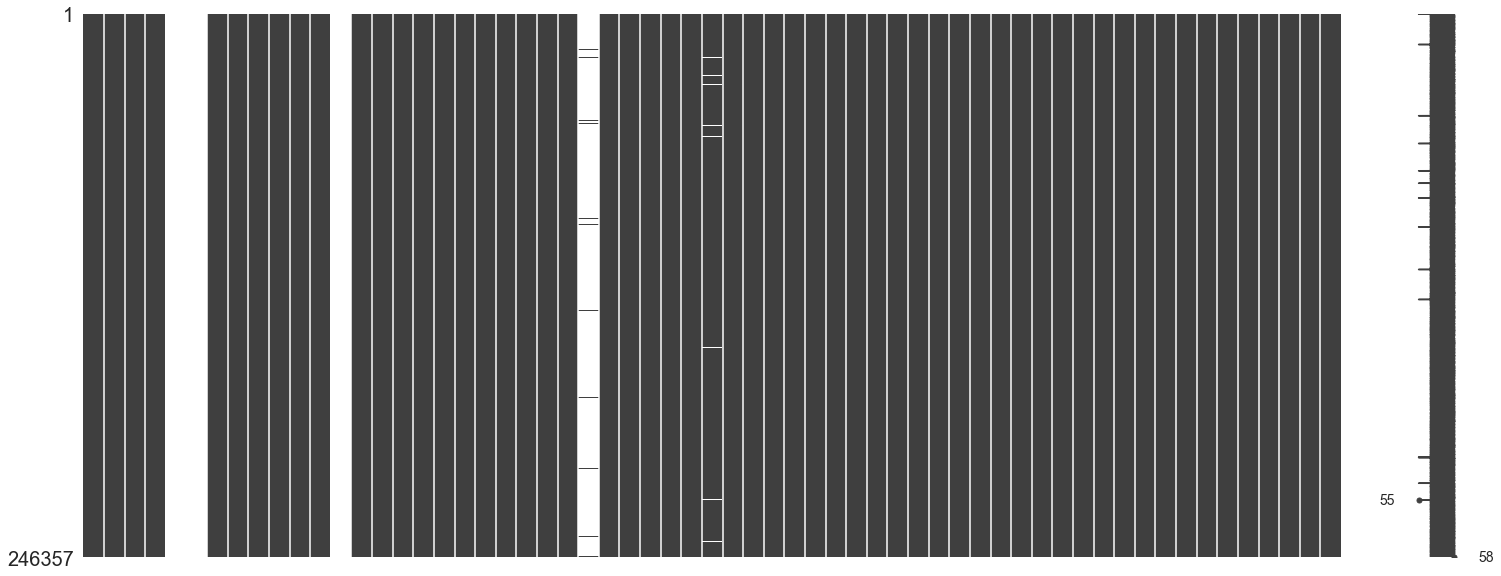

In [63]:
msno.matrix(paris_mutation)
plt.show()

In [7]:
def to_date_col(df, col= "datemut", formated= "%Y-%m-%d"):
    return pd.to_datetime(df[col], format= "%Y-%m-%d")

# paris_mutation["datemut"]= pd.to_datetime(paris_mutation["datemut"], format= "%Y-%m-%d")
paris_mutation["datemut"]= to_date_col(paris_mutation
                                      )
print("Pétiode d'étude :")
print(str(paris_mutation["datemut"].min()))
print(str(paris_mutation["datemut"].max()))

Pétiode d'étude :
2014-01-02 00:00:00
2019-12-31 00:00:00


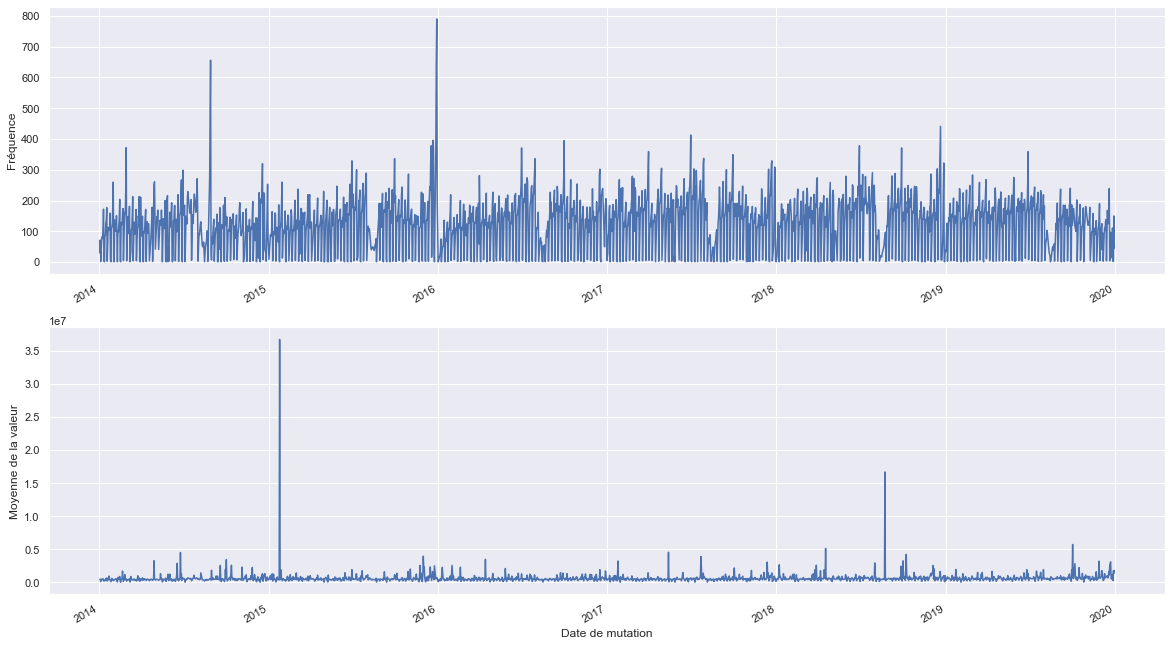

In [65]:
grouped_datemut= paris_mutation.groupby(["datemut"])

fig, ax= plt.subplots(2, 1, figsize= (20, 12))

grouped_datemut.count()["idmutation"].plot(ax= ax[0])
ax[0].set_xlabel("")
ax[0].set_ylabel("Fréquence")

grouped_datemut.mean()["valeurfonc"].plot(ax= ax[1])
ax[1].set_xlabel("Date de mutation")
ax[1].set_ylabel("Moyenne de la valeur")

plt.show()

On a une fréquence d'observation plutôt stable dans le temps, tout comme la moyenne à quelques dates mois près.

In [66]:
paris_mutation["moismut"]

0          5
1          3
2          8
3         11
4          1
          ..
246352     2
246353     2
246354     9
246355     2
246356     6
Name: moismut, Length: 246357, dtype: int64

<a id= "type_de_bien"></a>

#### a. Le type de bien

In [67]:
paris_mutation["libtypbien"].value_counts()/paris_mutation.shape[0]

UN APPARTEMENT                               0.725873
UNE DEPENDANCE                               0.105221
ACTIVITE                                     0.063335
DEUX APPARTEMENTS                            0.038801
BATI MIXTE - LOGEMENT/ACTIVITE               0.015819
DES DEPENDANCES                              0.015141
APPARTEMENT INDETERMINE                      0.014211
BATI - INDETERMINE : Vefa sans descriptif    0.013984
UNE MAISON                                   0.003523
BATI - INDETERMINE : Vente avec volume(s)    0.002878
TERRAIN ARTIFICIALISE MIXTE                  0.000576
TERRAIN DE TYPE TAB                          0.000252
BATI MIXTE - LOGEMENTS                       0.000199
DES MAISONS                                  0.000126
TERRAIN DE TYPE RESEAU                       0.000032
TERRAIN D'AGREMENT                           0.000024
MAISON - INDETERMINEE                        0.000004
Name: libtypbien, dtype: float64

In [68]:
assert paris_mutation["idmutation"].nunique() == paris_mutation.shape[0]

<a id= "nature_mutation"></a>

#### b. La nature de la mutation

In [69]:
paris_mutation["libnatmut"].value_counts()/paris_mutation.shape[0]

Vente                                 0.970632
Vente en l'état futur d'achèvement    0.022228
Echange                               0.004075
Adjudication                          0.002906
Vente terrain à bâtir                 0.000110
Expropriation                         0.000049
Name: libnatmut, dtype: float64

La plus grosse partie des mutations sont des ventes d'appartement ou bien de dépendance (garage, place de parking etc.).

De plus, on a énormément de variables redondantes / inutiles qu'il nous faut retraîter. Par exemple :

- datemut
- anneemut
- moismut
- coddep
- ...

Enfin, il va falloir unstack certaines variables : sbati, nblocmai, nblocapt, nblocdep, nblocact ont les gardent ; mais pour les autres on va chercher à récupérer l'information à partir du nom de la colonne.

In [70]:
# Select all columns with the pattern nb*pp
def find_col_pattern(df, pattern):
    """
    """
    return df.filter(regex= (pattern)).columns

col_apt_pp= find_col_pattern(paris_mutation, "nba[a-zA-Z]*\dpp")
col_mai_pp= find_col_pattern(paris_mutation, "nbm[a-zA-Z]*\dpp")

In [71]:
type_bien= ["UN APPARTEMENT", "UNE MAISON"]
paris_mutation= paris_mutation[paris_mutation["libtypbien"].isin(type_bien)]
# We unstack all columns concerned : we get one column, with late column name as value
serie_pp= paris_mutation[list(col_apt_pp) + list(col_mai_pp)].idxmax(1)

# We are looking for the number in column name
pattern_num= re.compile("\d{1}")
serie_pp= serie_pp.apply(lambda x: int(re.findall(pattern_num, x)[0])) # we are going to add it later
paris_mutation["pp"]= serie_pp

# # We can drop useless columns
col_apt_s= find_col_pattern(paris_mutation, "sa[a-zA-Z]*\dpp")
col_mai_s= find_col_pattern(paris_mutation, "sm[a-zA-Z]*\dpp")

paris_mutation= paris_mutation.drop(columns= list(col_apt_pp) + list(col_mai_pp) + list(col_apt_s)\
                                   + list(col_mai_s))

C:\Users\wenceslas\anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


A partir de là, nous allons uniquement travailler sur les mutations d'**un appartement** ou d'**une maison**; plusieurs raisons à cela :
- certaintes transactions sont liées à des activités de promoteurs
- certains type de transaction dénote du nombre de bien échangé; le problème c'est qu'on ne sait pas comment séparer l'information du prix (ou bien de la surface du bien si celui ci à le même nombre de pièce).

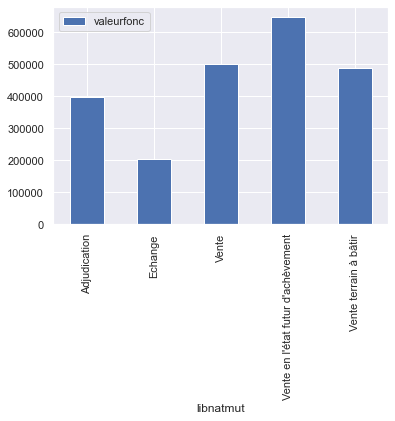

In [72]:
paris_mutation[["libnatmut", "valeurfonc"]].groupby(["libnatmut"]).mean().plot.bar()

In [73]:
type_mut= ["Adjudication", "Echange"]
paris_mutation= paris_mutation[~paris_mutation["libnatmut"].isin(type_mut)]

Enfin, on va uniquement se concentrer sur les véritables ventes (on enlève "Adjudication" et "Echange"). On pourra supprimer la variable `libnatmut` dans la partie suivante.

<a id= "traitement"></a>

### B. Le traitement des variables

<a id= "useless"></a>

#### a. Certaines variables sont inutiles

In [74]:
# Delete some variables
paris_mutation= paris_mutation.drop(columns= ["codtypbien", "idmutinvar", "idopendata"
                                             , "codservch", "refdoc", "nbartcgi", "vefa"])
# nbartcgi unique value 0

In [75]:
def col_over_thresh(df, col, thresh):
    """
    """
    try:
        ppt= (df[col].value_counts()/df.shape[0]).values[0]
        if ppt >= thresh:
            return True
        else:
            return False
    except:
        return False
    
thresh= 0.99
dont_keep_col= []
for col in paris_mutation.columns:
    if col_over_thresh(paris_mutation, col, thresh):
        dont_keep_col.append(col)
    else:
        continue

print(dont_keep_col)

['idnatmut', 'coddep', 'libnatmut', 'nbdispo', 'nbcomm', 'nbsection', 'nbparmut', 'nbsuf', 'sterr', 'l_dcnt', 'nbvolmut', 'nblocmai', 'nblocapt', 'nblocact', 'sbatmai', 'sbatact', 'libtypbien']


Certaines variables ont très souvent les mêmes valeurs : étudions les.

In [76]:
paris_mutation[dont_keep_col].head()

,idnatmut,coddep,libnatmut,nbdispo,nbcomm,nbsection,nbparmut,nbsuf,sterr,l_dcnt,nbvolmut,nblocmai,nblocapt,nblocact,sbatmai,sbatact,libtypbien
1,1,75,Vente,1,1,1,0,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",0,0,1,0,0,0,UN APPARTEMENT
3,1,75,Vente,1,1,1,0,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",0,0,1,0,0,0,UN APPARTEMENT
7,2,75,Vente en l'état futur d'achèvement,1,1,1,0,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",0,0,1,0,0,0,UN APPARTEMENT
10,1,75,Vente,1,1,1,0,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",0,0,1,0,0,0,UN APPARTEMENT
13,1,75,Vente,1,1,1,0,0,0,"{0,0,0,0,0,0,0,0,0,0,0,0,0}",0,0,1,0,0,0,UN APPARTEMENT


In [77]:
paris_mutation= paris_mutation.drop(columns= dont_keep_col)
paris_mutation= paris_mutation.drop(columns= ["anneemut", "moismut", "l_artcgi"
                                             , "l_idpar", "l_section", "l_idparmut"
                                             , "l_idlocmut", "sbatapt"])

In [78]:
paris_mutation["sbati_square"]= paris_mutation["sbati"]*paris_mutation["sbati"]

In [79]:
paris_mutation["valeurfonc_per_s"]= paris_mutation["valeurfonc"]/paris_mutation["sbati"]

In [80]:
paris_mutation.head()

,idmutation,datemut,valeurfonc,nblot,l_codinsee,nbpar,nblocmut,nblocdep,sbati,pp,sbati_square,valeurfonc_per_s
1,5454034,2017-03-07,207000.0,3,{75118},1,1,0,39,3,1521,5307.692308
3,5183819,2019-11-27,220000.0,2,{75115},1,1,0,21,2,441,10476.190476
7,5186543,2019-07-04,455000.0,1,{75118},1,1,0,61,3,3721,7459.016393
10,5603750,2016-11-30,220000.0,1,{75116},1,1,0,25,1,625,8800.000000
13,5340190,2018-08-30,295000.0,1,{75115},1,1,0,29,1,841,10172.413793


<a id="missing"></a>

#### b. Traitement des valeurs manquantes

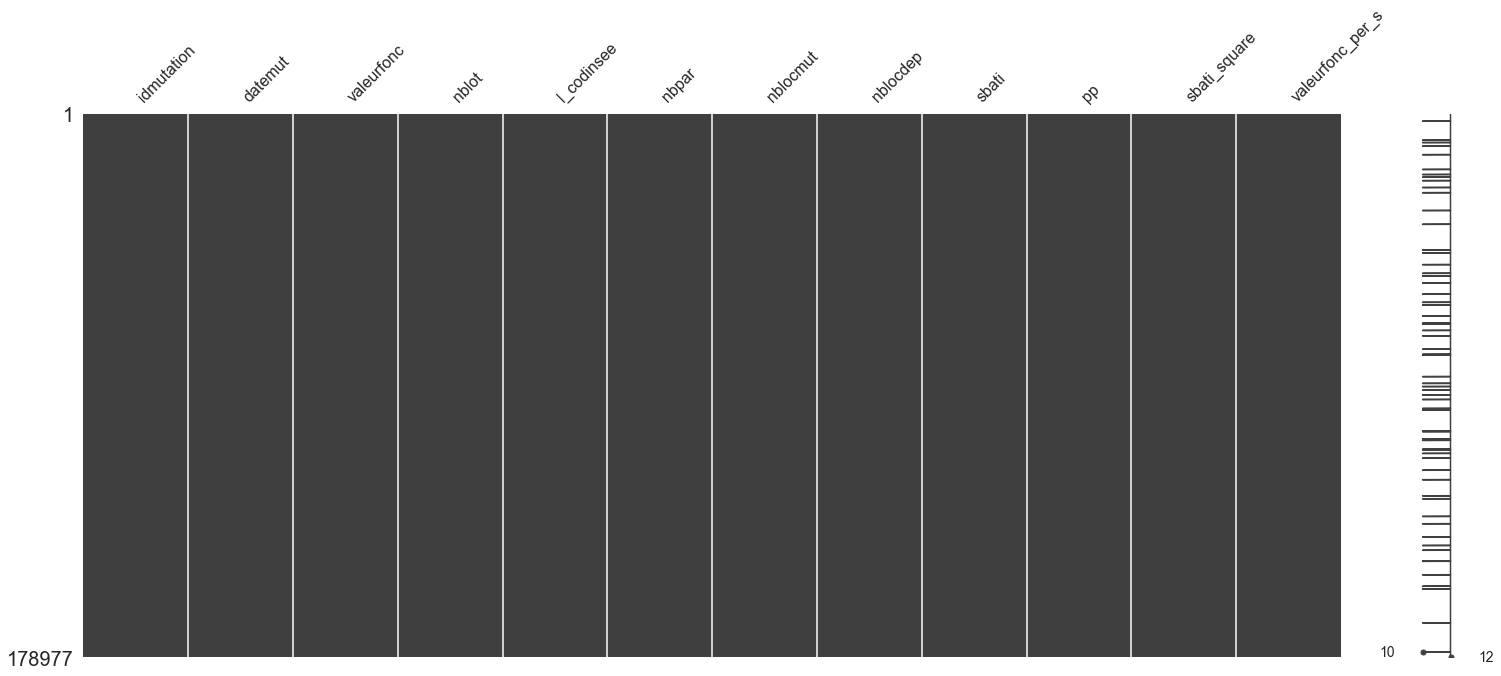

In [81]:
msno.matrix(paris_mutation)
plt.show()

Après retraitement de nos champs la définition du périmètre, on remarque que n'avons peu de valeurs manquantes (la missing matrix est quasiment noire) :

In [82]:
paris_mutation.isnull().sum()/paris_mutation.shape[0]

idmutation          0.000000
datemut             0.000000
valeurfonc          0.000352
nblot               0.000000
l_codinsee          0.000000
nbpar               0.000000
nblocmut            0.000000
nblocdep            0.000000
sbati               0.000000
pp                  0.000000
sbati_square        0.000000
valeurfonc_per_s    0.000352
dtype: float64

Essayons de voir si les valeurs manquantes du champ `valeurfonc` sont liées à une modalité d'une autre variable du dataset.

In [83]:
paris_mutation["missing"]= np.where(paris_mutation["valeurfonc"].isnull(), 1, 0) 

In [84]:
paris_mutation[["missing", "nblocmut"]]

,missing,nblocmut
1,0,1
3,0,1
7,0,1
10,0,1
13,0,1
...,...,...
246350,0,1
246352,0,1
246353,0,2
246354,0,1


In [85]:
col_to_boxplot= [col_int for col_int in paris_mutation.columns 
                 if (paris_mutation[col_int].dtypes in ["int64", "float64"]) \
                 & (col_int not in ["idmutation", "missing", "valeurfonc", "valeurfonc_per_s"])]

In [86]:
col_to_boxplot

['nblot', 'nbpar', 'nblocmut', 'nblocdep', 'sbati', 'pp', 'sbati_square']

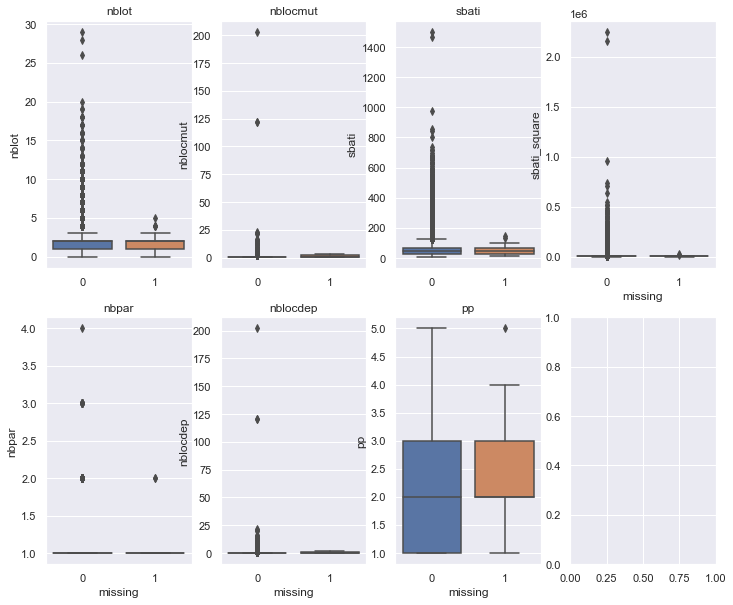

In [87]:
fig, ax= plt.subplots(2, 4, figsize= (12, 10))

for i in range(4):
    sns.boxplot(x= "missing", y= col_to_boxplot[2*i]
                , data= paris_mutation
                , ax= ax[0, i], orient= "v")
    try:
        sns.boxplot(x= "missing", y= col_to_boxplot[2*i + 1]
                    , data= paris_mutation
                    , ax= ax[1, i], orient= "v")
    except:
        continue
    ax[0, i].set_title(col_to_boxplot[2*i])
    ax[1, i].set_title(col_to_boxplot[2*i + 1])
    ax[0, i].set_xlabel("")

Pour rappel, on cherche à savoir si les valeurs manquantes de `valeurfonc` sont liées aux caractéristiques de la mutation. A première vue, cela ne semble pas être le cas : les boxplot sont similaires pour les observations avec valeurs manquantes et sans; aux outliers près (ce qui ne nous dérange pas étant donné la faible proportion de valeurs manquantes). 

Pour conclure, nous allons comparer les moyennes des variables sachant la valeur manquantes dansle temps (par mois et par ans)

In [88]:
group_paris_month= paris_mutation.copy()
group_paris_month["month"]= group_paris_month["datemut"].apply(lambda x: x.month)
group_paris_month["year"]= group_paris_month["datemut"].apply(lambda x: x.year)

In [89]:
def groupby_bar(df, date_group, to_display, ax= None, func= "count", color= "pink"
                , line= True, alpha= 1):
    """
    """
    if func not in ["count", "mean"]:
        raise ValueError
    elif func == "count":
        data= df.groupby(date_group).count()[to_display]
        data.plot.bar(ax= ax, color= color, alpha= alpha)
        plt.ylabel("Frequence")
    else:# func == "mean":
        data= df.groupby(date_group).mean()[to_display]
        data.plot.bar(ax= ax, color= color, alpha= alpha)
        
        if line:
            ax2= plt.twiny(ax= ax)    
            data.plot.line(ax= ax2)

            ax2.grid(False)
            ax2.set_xticks([])
#         ax2.set_yticks(ax.get_yticks())
        plt.ylabel("Moyenne")
        
    ax.set_title(to_display)
    
    pass

In [90]:
group_paris_month_missing= group_paris_month[group_paris_month["missing"] == 1]
group_paris_month_not_missing= group_paris_month[group_paris_month["missing"] == 0]

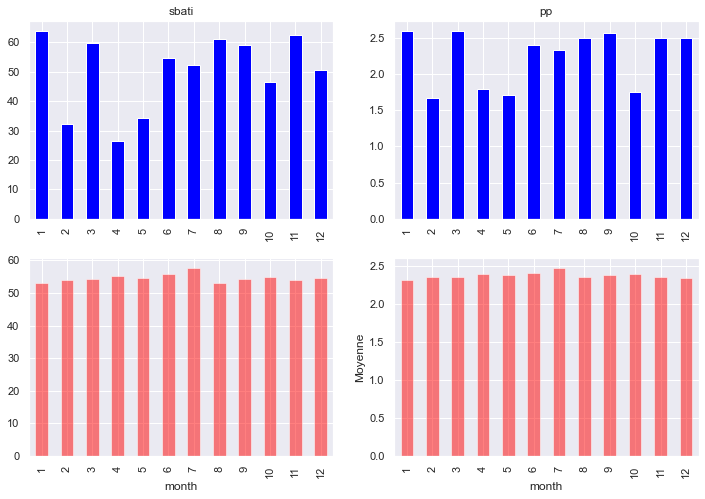

In [91]:
fig, ax= plt.subplots(2, 2, figsize= (12, 8))

to_plot= ["sbati", "pp"]
for i in range(2):
    groupby_bar(group_paris_month_missing, "month", to_plot[i], func= "mean"
                , ax= ax[0, i], line= False, color= "blue")
    groupby_bar(group_paris_month_not_missing, "month", to_plot[i]
                , func= "mean", ax= ax[1, i], alpha= 0.5, color= "red", line= False)
    ax[1, i].set_title("")
    ax[0, i].set_xlabel("")

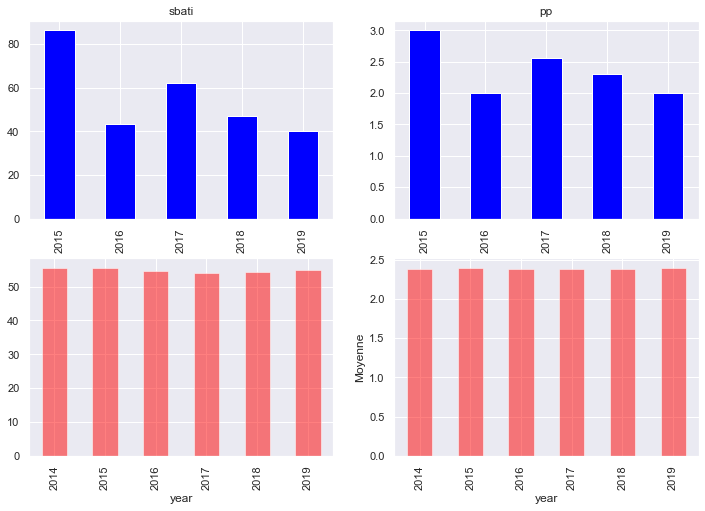

In [92]:
fig, ax= plt.subplots(2, 2, figsize= (12, 8))

to_plot= ["sbati", "pp"]
for i in range(2):
    groupby_bar(group_paris_month_missing, "year", to_plot[i], func= "mean"
                , ax= ax[0, i], line= False, color= "blue")
    groupby_bar(group_paris_month_not_missing, "year", to_plot[i]
                , func= "mean", ax= ax[1, i], alpha= 0.5, color= "red", line= False)
    ax[0, i].set_xlabel("")
    ax[1, i].set_title("")

On remarque que les distributions sont différentes pour chacunesdes variables sachant la valeur manquante, néanmoins, il est difficile de conclure étant donné le faible nombre d'observation manquante. A vrai dire, il faudrait aussi comparer les histogrammes etc. Mais il y a tellement peu de valeurs manquantes et celles-ci semblent être aléatoires **qu'on a donc décidé de s'en séparer**.

In [93]:
print(paris_mutation.shape)
paris_mutation= paris_mutation.dropna()
print(paris_mutation.shape)

(178977, 13)
(178914, 13)


Dorénavant, nous allons nous concentrer sur l'analyse de nos variables

<a id="comprendre"></a>

#### c. Comprendre les variables restantes

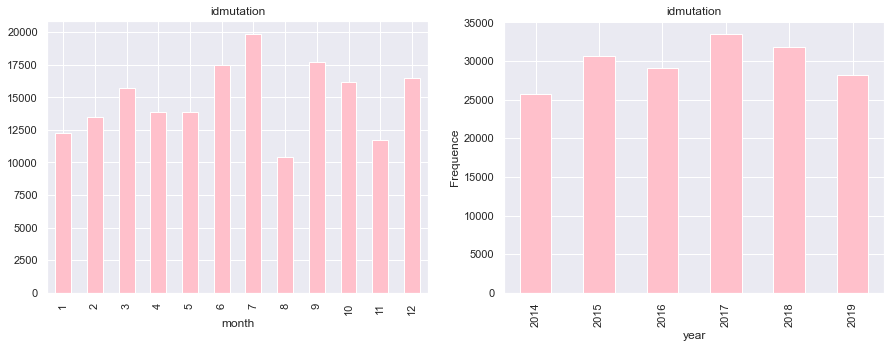

In [94]:
fig, ax= plt.subplots(1, 2, figsize= (15, 5))

groupby_bar(group_paris_month, "month", "idmutation", func= "count", ax= ax[0])
groupby_bar(group_paris_month, "year", "idmutation", func= "count", ax= ax[1])

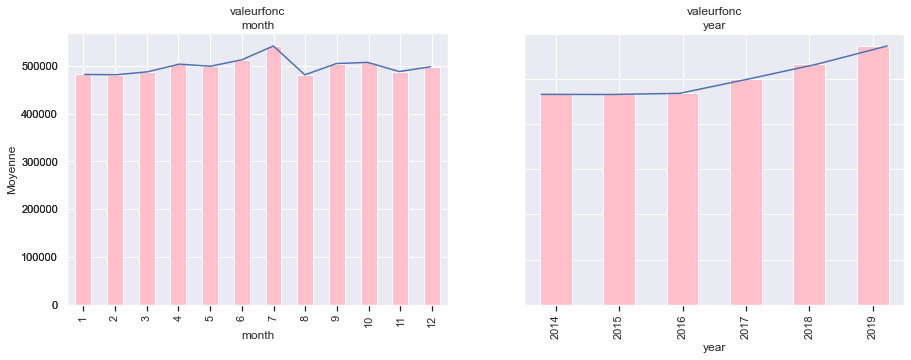

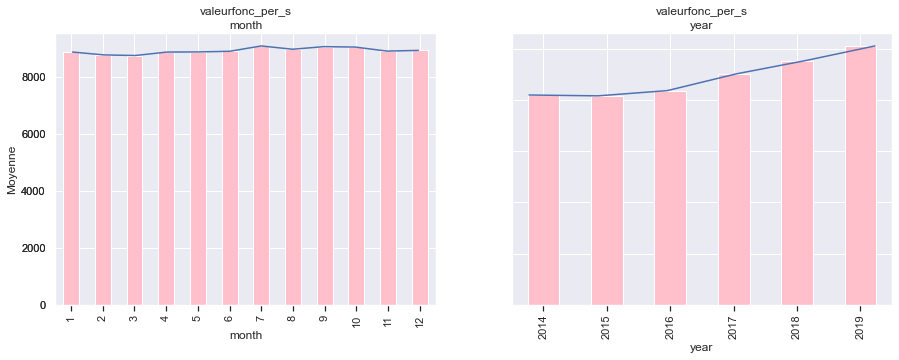

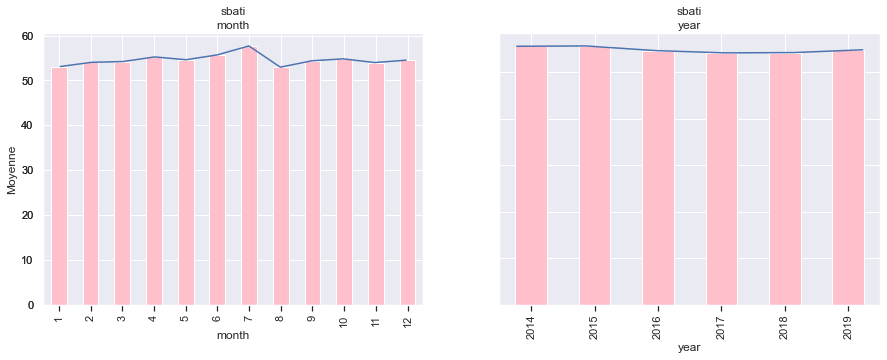

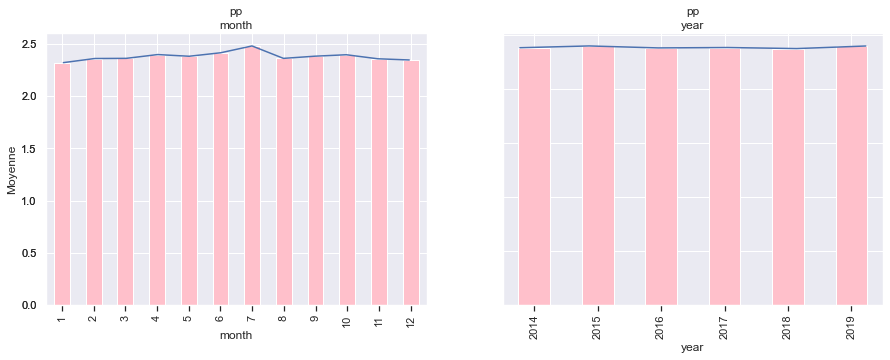

In [95]:
for col in ["valeurfonc", "valeurfonc_per_s", "sbati", "pp"]:
    fig, ax= plt.subplots(1, 2, figsize= (15, 5))

    groupby_bar(group_paris_month, "month", col, func= "mean", ax= ax[0])
    groupby_bar(group_paris_month, "year", col, func= "mean", ax= ax[1])

Rien à signaler **SAUF** pour l'évolution de la valeur foncière moyenne par année : elle est en croissance de 2016 à 2019. Est-ce lié à la croissance du marché immobilier parisien, à l'inflation ? C'est important de comprendre pourquoi et d'essayer d'y remédier car, en théorie dans les modèles, on ne prendra pas en compte les variables temporelles. Ainsi, si la valeur foncière dépend du temps, notre modèle aura un biai de variable omise.

C'est pourquoi on est allé cherché l'indice de référence des loyers (IRL) calculé par l'INSEE tous les trimestre, tout comme l'indice des prix à la consommation.

In [96]:
col_to_boxplot= [col_int for col_int in paris_mutation.columns 
                 if (paris_mutation[col_int].dtypes in ["int64", "float64"]) & (col_int not in ["idmutation"])]

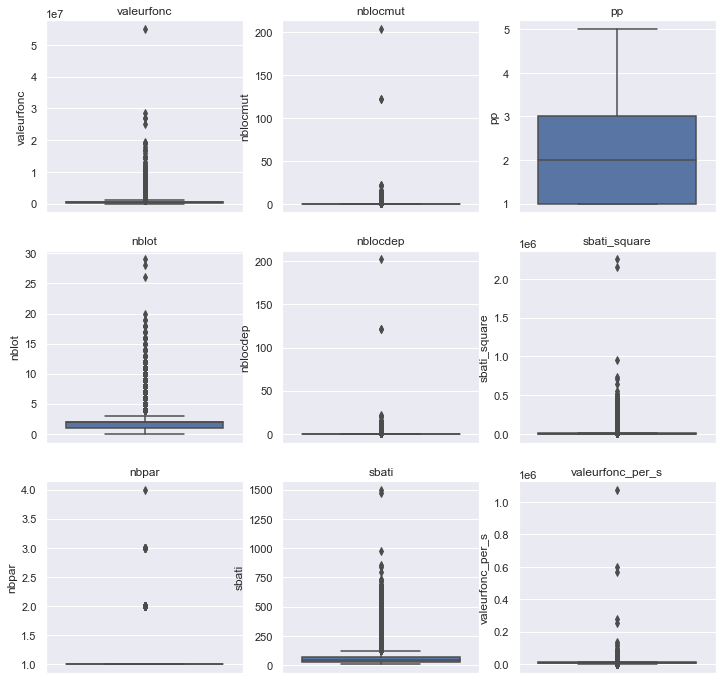

In [97]:
fig, ax= plt.subplots(3, 3, figsize= (12, 12))

for i in range(3):
    sns.boxplot(y= col_to_boxplot[3*i]
                , data= paris_mutation
                , ax= ax[0, i], orient= "v")
    sns.boxplot(y= col_to_boxplot[3*i + 1]
                , data= paris_mutation
                , ax= ax[1, i], orient= "v")
    sns.boxplot(y= col_to_boxplot[3*i + 2]
                , data= paris_mutation
                , ax= ax[2, i], orient= "v")
    
    ax[0, i].set_title(col_to_boxplot[3*i])
    ax[1, i].set_title(col_to_boxplot[3*i + 1])
    ax[2, i].set_title(col_to_boxplot[3*i + 2])

<a id= "insee"></a>

#### d. Comment prendre en compte l'évolution du prix des biens immobiliers ?

In [98]:
irl_insee= pd.read_csv("data/insee/insee_irl.csv", delimiter= ";")

In [99]:
pattern_num= re.compile("T(\d{1})")
irl_insee["quarter"]= irl_insee["t"].apply(lambda x: int(re.findall(pattern_num, x)[0])) # we are going to add it later
irl_insee= irl_insee.drop(columns= ["t"])

On va reconstruire l'indice en partant de 2014 qui est la date min de notre dataset. C'est à dire, que la base 100 sera le premier trimestre 2014.

In [100]:
irl_insee= irl_insee.sort_values(by= ["annee", "quarter"], ascending= True).reset_index(drop= True)
irl_insee["irl_minus"]= irl_insee["irl"].shift(1)
irl_insee["rate"]= 1+(irl_insee["irl"]- irl_insee["irl_minus"])/irl_insee["irl_minus"] # pour le cumprod
irl_insee["rate_cumprod"]= irl_insee["rate"].cumprod()

irl_insee["irl_reel"]= 100 * irl_insee["rate_cumprod"]
irl_insee["irl_reel"]= irl_insee["irl_reel"].fillna("100")
irl_insee["rate_cumprod"]= irl_insee["rate_cumprod"].fillna("1")

irl_insee= irl_insee.drop(columns= ["irl_minus", "rate"])

In [101]:
paris_mutation["quarter"]= paris_mutation["datemut"].apply(lambda x: (x.month - 1)//3 + 1)
paris_mutation["annee"]= paris_mutation["datemut"].dt.year

In [102]:
paris_mutation= paris_mutation.merge(irl_insee, how= "left", on= ["annee", "quarter"])

In [103]:
# we change the type of irl_reel
paris_mutation["irl_reel"]= paris_mutation["irl_reel"].astype("float64") 
paris_mutation["rate_cumprod"]= paris_mutation["rate_cumprod"].astype("float64") 

In [104]:
paris_mutation["valeurfonc_reel"]= 100*(paris_mutation["valeurfonc"]/paris_mutation["irl_reel"])
paris_mutation["valeurfonc_per_s_reel"]= 100*(paris_mutation["valeurfonc_per_s"]\
                                              /paris_mutation["irl_reel"])

Est ce pertinent ?

In [105]:
group_paris_month= paris_mutation.copy()
group_paris_month= group_paris_month.groupby(["annee"], as_index= False).mean()

In [106]:
def plot_line(df, x, y, ax, label):
    """
    """
    sns.lineplot(data= df, x= x, y= y, ax= ax, label= label)
    pass

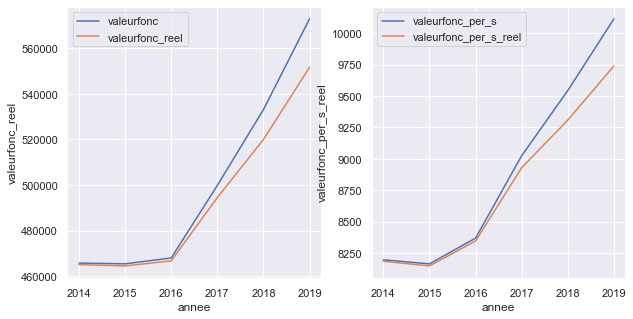

In [107]:
col_plot= ["valeurfonc", "valeurfonc_per_s", "valeurfonc_reel", "valeurfonc_per_s_reel"]

fig, ax= plt.subplots(1, 2, figsize= (10, 5))

for i in range(2):
    plot_line(group_paris_month, "annee", col_plot[2*i], ax[0], label= col_plot[2*i])
    plot_line(group_paris_month, "annee", col_plot[2*i+1], ax[1], label= col_plot[2*i+1])

Houla, les résultats ne sont pas concluant, essayons avec l'indice IRL de base.

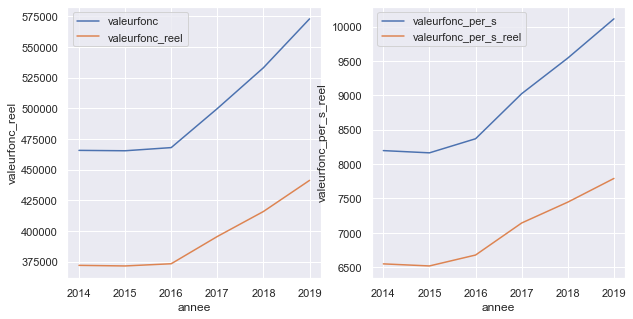

In [108]:
for col in ["valeurfonc_per_s_reel", "valeurfonc_per_s_reel"]:
    paris_mutation[col]= paris_mutation[col].astype("float64")

paris_mutation["valeurfonc_reel"]= 100*(paris_mutation["valeurfonc"]/paris_mutation["irl"])
paris_mutation["valeurfonc_per_s_reel"]= 100*(paris_mutation["valeurfonc_per_s"]\
                                              /paris_mutation["irl"])

group_paris_month= paris_mutation.copy()
group_paris_month= group_paris_month.groupby(["annee"], as_index= False).mean()

fig, ax= plt.subplots(1, 2, figsize= (10, 5))

for i in range(2):
    plot_line(group_paris_month, "annee", col_plot[2*i], ax[0], label= col_plot[2*i])
    plot_line(group_paris_month, "annee", col_plot[2*i+1], ax[1], label= col_plot[2*i+1])

Pas concluant non plus. On va essayer une dernière chose mais cette fois-ci avec l'inflation.

In [109]:
inflation= pd.read_csv("data/insee/estat_ei_cphi_m_filtered.csv")

In [110]:
inflation= inflation.T.reset_index()
inflation.columns= inflation.iloc[0, :]
inflation= inflation.iloc[1:, :]
inflation= inflation.reset_index(drop= True)

In [111]:
inflation["TIME_PERIOD"]= inflation["TIME_PERIOD"].apply(lambda x: x.strip()+"-01")
inflation["TIME_PERIOD"]= pd.to_datetime(inflation["TIME_PERIOD"], format= "%Y-%m")

In [112]:
paris_mutation= paris_mutation.merge(inflation, how= "left"
                                     , left_on= paris_mutation["datemut"].apply(lambda x: (x.year, x.month))
                                     , right_on= inflation["TIME_PERIOD"].apply(lambda x: (x.year, x.month)))
paris_mutation= paris_mutation.drop(columns= ["TIME_PERIOD"])

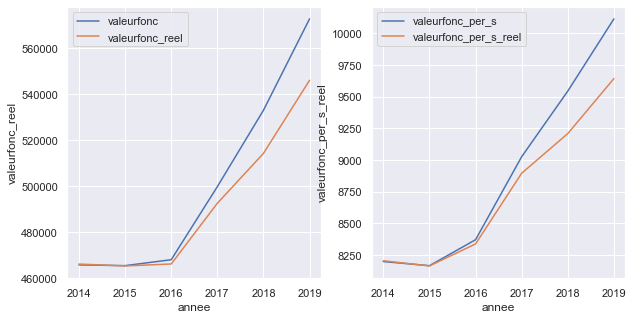

In [113]:
for col in ["valeurfonc_per_s_reel", "valeurfonc_per_s_reel", "FR"]:
    paris_mutation[col]= paris_mutation[col].astype("float64") 
    
paris_mutation["valeurfonc_reel"]= 100*(paris_mutation["valeurfonc"]/paris_mutation["FR"])
paris_mutation["valeurfonc_per_s_reel"]= 100*(paris_mutation["valeurfonc_per_s"]\
                                              /paris_mutation["FR"])
group_paris_month= paris_mutation.copy()
group_paris_month= group_paris_month.groupby(["annee"], as_index= False).mean()

fig, ax= plt.subplots(1, 2, figsize= (10, 5))

for i in range(2):
    plot_line(group_paris_month, "annee", col_plot[2*i], ax[0], label= col_plot[2*i])
    plot_line(group_paris_month, "annee", col_plot[2*i+1], ax[1], label= col_plot[2*i+1])

On a les mêmes résultats : on s'y attendait un peu car l'indice IRL est en partie calculé grâce à l'inflation. On ne peut donc pas corriger la hausse du prix moyen dans le temps des mutations. Il faudra en prendre compte lors de la modélisation.

<a id="corr"></a>

#### e. Enfin, la corrélation de nos variables

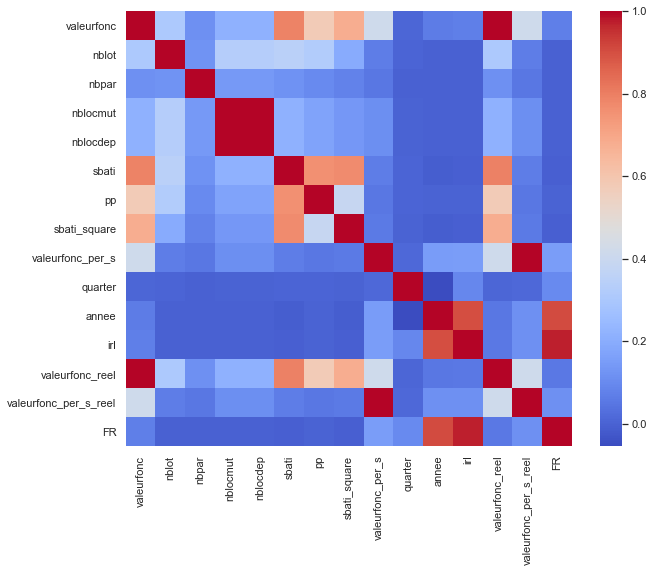

In [114]:
fig= plt.figure(figsize= (10 ,8))
corr_to_plot= paris_mutation.drop(columns= ["key_0", "idmutation", "datemut", "missing"
                                           , "rate_cumprod", "irl_reel"])
corr = corr_to_plot.corr()

sns.heatmap(corr, 
            xticklabels= corr.columns.values
            , yticklabels= corr.columns.values
            , cmap='coolwarm')

De cette matrice de variance covariance, on en retire les informations suivantes :
- la valeurfonc est corrélée à la surface du bien, aux nombres de pièces
- les variables que nous avons calculées à l'aide des champs disponibles sont corrélées à leur support (obvious).
- la surface et le nombre de pièce sont corrélés (plus j'ai de pièce, plus la surface du bien sera grande).
- 

Bonus :
- FR, l'indice des prix est très fortement corrélées à l'année **et** à l'indice IRL (ce qui je le rappelle est normal car l'IRL est un indice des prix modifié).

In [116]:
paris_mutation= paris_mutation.drop(columns= ["key_0", "missing", "irl_reel", "annee", "quarter"])
paris_mutation.to_csv("data/saved/paris_mutation_data.csv", index= False)

<a id= "synthese_mut"></a>

### C. Synthèse : la table mutation

<a id="geo"></a>

## 2) Représentation géospatiale de nos données

<a id= "avenger"></a>

### A. Prise en main des différents dataset

In [9]:
paris_mutation= pd.read_csv("data/saved/paris_mutation_data.csv")
paris_mutation["datemut"]= to_date_col(paris_mutation)

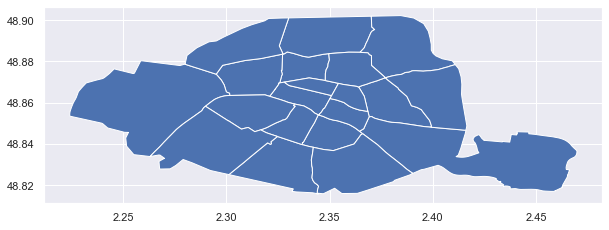

In [11]:
paris= gdp.read_file("data/map/paris/arrondissements.shp")
paris["c_arinsee"]= paris["c_arinsee"].apply(int)
paris_crs= {'init': 'epsg:4326'}
paris.plot(figsize= (10, 10))
plt.show()

In [12]:
mutation_geolocpoint= gdp.read_file("data/unziped_csv/r11/r11_mutation_geomlocmut.shp")
mutation_geolocpoint.columns= map(str.lower, mutation_geolocpoint)
mutation_geolocpoint["geometry"]= mutation_geolocpoint["geometry"].to_crs(epsg=4326)

mutation_geolocpoint.crs= paris_crs
# mutation_geolocpoinft.plot()

C:\Users\wenceslas\anaconda3\envs\cours\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [13]:
mutation_geolocpar= gdp.read_file("data/unziped_csv/r11/r11_mutation_geompar.shp")
mutation_geolocpar.columns= map(str.lower, mutation_geolocpar)
mutation_geolocpar["geometry"]= mutation_geolocpar["geometry"].to_crs(epsg=4326)

mutation_geolocpoint.crs= paris_crs
# mutation_geolocpar.plot()

C:\Users\wenceslas\anaconda3\envs\cours\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
print(paris_mutation["l_codinsee"].unique())
# Some mutation appears in two arrondissement, so we created 2 columns, the second with a different
# value if it has two arrondissement
paris_mutation["arr1"]= paris_mutation["l_codinsee"].str.replace("{", "").str.replace("}", "")\
.str[:5].apply(int)

paris_mutation["arr2"]= paris_mutation["l_codinsee"].str.replace("{", "").str.replace("}", "")\
.apply(lambda x: int(x[6:]) if len(x) > 6 else int(x[:5]))

print((paris_mutation["arr1"] != paris_mutation["arr2"]).sum())

['{75118}' '{75115}' '{75116}' '{75110}' '{75101}' '{75103}' '{75120}'
 '{75105}' '{75109}' '{75111}' '{75106}' '{75107}' '{75119}' '{75104}'
 '{75108}' '{75113}' '{75114}' '{75117}' '{75102}' '{75112}'
 '{75119,75120}' '{75109,75110}' '{75106,75107}']
10


In [15]:
paris_mutation= gdp.GeoDataFrame(paris_mutation)

On va merger tous nos dataset geopandas pour récupérer les différents polygones nécessaires pour les plot de map.

<a id= "agrege"></a>

#### a. Agréger les différentes tables

In [17]:
paris_mutation= paris_mutation.merge(mutation_geolocpoint, how= "left", on= "idmutation")
paris_mutation= paris_mutation.rename(columns= {"geometry": "geometry_point"})

In [19]:
paris_mutation= paris_mutation.merge(mutation_geolocpar, how= "left", on= "idmutation")
paris_mutation= paris_mutation.rename(columns= {"geometry": "geometry_par"})

# We can swap geometry col with this formula
def swap_geometry(df, col_to_set, geometry= "geometry", base_crs= paris_crs):
    """
    Set our CRS when we change geometry column
    """
    df[col_to_set]= gdp.GeoSeries(df[col_to_set]).centroid
    df[geometry]= df[col_to_set]
    df[col_to_set].crs= base_crs
    df[geometry]= df[col_to_set]
    df[geometry].crs= base_crs
    return df


paris_mutation= swap_geometry(paris_mutation, "geometry_point")

In [25]:
print(sum(paris_mutation["geometry_par"] == None))
print(sum(paris_mutation["geometry_point"] == None))
print(sum((paris_mutation["geometry_point"] == None) & (paris_mutation["geometry_par"] == None)))

48
48
48


On a des valeurs de `geometry_point` qui sont manquantes pour Paris, et le même nombre pour les parcelles. Par principe de précaution, on va remplacer les Point par les centroids des parcelles. Cela nous permettra d'obtenir des Point bien au centre des parcelles pour l'aspect data viz.

In [29]:
def find_index_col(df, col):
    """ sert à rien pour l'instant
    """
    return np.where(np.array(df.columns) == col)

geopar_index= find_index_col(paris_mutation, "geometry_par")
geopoint_index= find_index_col(paris_mutation, "geometry_point")
geo_index= find_index_col(paris_mutation, "geometry")

In [30]:
paris_mutation["geometry_parpoint"]= gdp.GeoSeries(paris_mutation["geometry_par"]).centroid
paris_mutation= swap_geometry(paris_mutation, "geometry_parpoint")

In [33]:
paris_mutation.head()

,idmutation,datemut,valeurfonc,nblot,l_codinsee,nbpar,nblocmut,nblocdep,sbati,pp,sbati_square,valeurfonc_per_s,irl,rate_cumprod,valeurfonc_reel,valeurfonc_per_s_reel,FR,arr1,arr2,geometry_point,geometry_par,geometry,geometry_parpoint
0,5454034,2017-03-07,207000.0,3,{75118},1,1,0,39,3,1521,5307.692308,125.90,1.00720,204001.182616,5230.799554,101.47,75118,75118,POINT (2.34927 48.89034),"POLYGON ((2.34915 48.89027, 2.34912 48.89042, ...",POINT (2.34927 48.89035),POINT (2.34927 48.89035)
1,5183819,2019-11-27,220000.0,2,{75115},1,1,0,21,2,441,10476.190476,130.26,1.04208,208986.415883,9951.734090,105.27,75115,75115,POINT (2.31513 48.84359),"POLYGON ((2.31506 48.84361, 2.31516 48.84364, ...",POINT (2.31513 48.84359),POINT (2.31513 48.84359)
2,5186543,2019-07-04,455000.0,1,{75118},1,1,0,61,3,3721,7459.016393,129.99,1.03992,432879.840167,7096.390822,105.11,75118,75118,POINT (2.35657 48.89727),"POLYGON ((2.35651 48.89742, 2.35663 48.89712, ...",POINT (2.35659 48.89722),POINT (2.35659 48.89722)
3,5603750,2016-11-30,220000.0,1,{75116},1,1,0,25,1,625,8800.000000,125.50,1.00400,218796.618598,8751.864744,100.55,75116,75116,POINT (2.28300 48.86192),"POLYGON ((2.28290 48.86183, 2.28285 48.86186, ...",POINT (2.28300 48.86192),POINT (2.28300 48.86192)
4,5340190,2018-08-30,295000.0,1,{75115},1,1,0,29,1,841,10172.413793,128.45,1.02760,282702.443699,9748.360128,104.35,75115,75115,POINT (2.28448 48.84956),"POLYGON ((2.28468 48.84964, 2.28441 48.84942, ...",POINT (2.28448 48.84956),POINT (2.28448 48.84956)


In [47]:
Point(0, 0).distance(Point(1, 1))

1.4142135623730951

In [61]:
paris_mutation_copy= paris_mutation.copy()
col_compute_diff= ["geometry_point", "geometry_parpoint"]

for col in col_compute_diff:
    paris_mutation_copy[col]= paris_mutation_copy[col].apply(lambda x: Point(0, 0) if (x == None) else x)

paris_mutation_copy["distance_diff"]= paris_mutation_copy[col_compute_diff].apply(
    lambda x: x[0].distance(x[1]), axis= 1) # euclidean norm

paris_mutation_copy["distance_diff"].describe()

count    178914.000000
mean          0.000035
std           0.000103
min           0.000000
25%           0.000007
50%           0.000017
75%           0.000037
max           0.014202
Name: distance_diff, dtype: float64

La moyenne de la différence des distances euclidiennes est faible. On peut considérer que le centroid de la parcelle est un bon proxy du champ `geometry_point`. Ce sera utile plus tard pour les map.

<a id= "geomap"></a>

#### b. Rapide analyse : découverte des outils de mapping de GeoPandas

In [ ]:
def plot_points_on_paris(df, col= "valeurfonc", city= paris, arr= "c_ar", show_arr= True):
    """
    
    """
    # dependence from mpl_toolkits.axes_grid1 import make_axes_locatable
    hfont= {'fontname':'Helvetica'} # import a new fontstyle
    ax= city.plot(figsize= (20, 20), color= 'lightgrey', linewidth= 0.5, edgecolor= 'white',)
    ax.axis("off")
    
    if show_arr:
    # Name arrondissement
        city_copy= city.copy()
        city_copy['geometry'] = city_copy['geometry'].centroid # we take the center of each arrondissment
        for arrondissement in city.index:
            city_loc= city_copy.iloc[arrondissement, :]
            ax.text(y= float(city_loc.geometry.y), x= float(city_loc.geometry.x)
                    , s= str(int(city_loc[arr]))+"eme", **hfont, color= "black", alpha= 0.5)
    
    # Manage legend size
    divider= make_axes_locatable(ax)
    cax= divider.append_axes("right", size= "5%", pad= 0.1)

    df.plot(ax= ax, markersize= 100#, color= "purple"
                             , alpha= 0.7, linewidth= 2, column= "valeurfonc"
                             , cmap= "gnuplot", legend= True
                             , cax= cax)
    ax.set_title(col+" on Paris", loc= "center", wrap= True, fontsize= 20, **hfont)
    
    plt.show()

In [ ]:
def top_n_val(df, col= "valeurfonc", n= 10):
    """
    
    """
    df= df.reset_index(drop= True)
    top_n_highest_price= df[col].sort_values(ascending= False).head(n)
    top_n_highest_price= df.iloc[top_n_highest_price.index, :]
    
    return top_n_highest_price

In [ ]:
plot_points_on_paris(top_n_val(paris_mutation, n= 100)
                     , city= paris)

Voici la répartition dans Paris du top 100 des biens de la table DVF. On remarque que ces points sont localisés autour du 8ème arrondissement. On observe une valeur aberante en <font color='yellow'>jaune</font> dans le 11ème (avec une valeur de plus d'un milliard d'€). Au delà, tous les points représentent aussi des valeurs élevées avec un max de 1.25 milliard d'€ et un min de 106 millions. Certains de ces points ne sont donc pas des appartements, mais probablement des immeubles entiers.

Que se passe t-il avec la répartition de ces points dans Paris si on se sépare des valeurs foncières très élevées ?

In [ ]:
top_n_val(paris_mutation, n= 100)["libtypbien"].value_counts()/100

In [ ]:
plot_points_on_paris(top_n_val(paris_mutation[paris_mutation["valeurfonc"] <= 2e+08]
                               , n= 100)
                     , city= paris)

plot_points_on_paris(top_n_val(paris_mutation[paris_mutation["valeurfonc"] <= 5e+06]
                               , n= 100)
                     , city= paris)

La première map représente le top 100 des valeurs inférieures ou égales à 200 millions d'€ et la seconde inférieures égales à 5 millions. Les logements les plus chères se situent toujours dans le 1er, le 2ème, le 8ème et le 9ème arrondissement.

Quand on se restreint aux valeurs inférieures à 5 millions, la dispersion est un peu plus homogène, mais toujours avec une densité de points plus forte à l'Ouest de la Ville Lumière. Le problème avec ces points et les valeurs foncières qu'ils représentent, c'est que certaines actions de vente ont été faites par des promoteurs, des entreprises ... qui n'ont évidemment par le même budget qu'un particulier. On va donc représenter les mêmes graphiques, mais en considérant cette fois-ci le type de bien qu'un particulier peut acquérir.

In [ ]:
type_bien= ["UN APPARTEMENT", "UNE MAISON", "UNE DEPENDANCE"]
plot_points_on_paris(top_n_val(paris_mutation[paris_mutation["libtypbien"].isin(type_bien)]
                               , n= 100)
                     , city= paris)
plot_points_on_paris(top_n_val(paris_mutation[paris_mutation["libtypbien"].isin(type_bien) \
                                              & (paris_mutation["valeurfonc"] <= 5e+06)]
                               , n= 100)
                     , city= paris)

On remarque que les logements / dépendances les plus chères sont localisés aux mêmes endroits : 0 l'Est du 16ème, puis dans le 6, 7, 8 et 9 ème arrondissement. Ce n'est pas aberrant de voir une telle concentration de logement couteux dans ce secteur : ce sont les Beaux Quartiers résidentiels de Paris !